In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


plt.style.use("seaborn-v0_8")
random_state = 42

# Decision Trees
- Can be applied to both regression and classification problems
- Advantages: Easily explainable, Graphically displayable, Natively handle qualitative predictors (without the need for encoding)
- Disadvantages: High variance (overfitting) (different subsets generate different results), Lower performance

---
### DecisionTreeRegressor
- For **CONTINUOUS** variables
- How to build a regression tree:
    - Split the predictor space (the possible values of the attributes $X_1,...,X_p$) into distinct and non-overlapping Regions $R_1, ..., R_J$, based on specific conditions (like $X_1 <3$, $X_2>5$, ...)
    - Consider the region $R_j$: take the mean ($\hat{y}_{R_j}$) of the response value (Y_train) for the training observations in $R_j$. **For every new/test sample that falls into region $R_j$, the prediction of the model (y_pred) is the mean value said above**.
    - The boundaries of the regions are theoretically the ones that minimize the RSS metric: $$ \underset{R_1, R_2, ..., R_J}{\text{argmin}} \sum_{j=1}^{J} \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2 $$
    where $\hat{y}_{R_j}$ is the mean response value for the training observations in $R_j$. 
    But it's computationally unfeasible to consider every possible combination, therefore it's used the **Recursive Binary Splitting**: this approach is top-down as it starts at the top of the tree (where all observations fall into a single region) and successively splits the predictor space into two new branches. It's greedy because, at each step, the algorithm chooses the best split at that particular region without consideration of the next steps.
        - At each step, the algorithm seeks for the predictor (variable $X_i$) and the cut point ($s$) defined like this: $$ R_1(j, s) = \{X|X_j \leq s\} \quad \text{and} \quad R_2(j, s) = \{X|X_j > s\} $$
        that lead to the greatest reduction in RSS equation: $$ \sum_{x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2 $$
        - Repeat the process until a stopping criterion, e.g.:
            - all node samples belong to the same attribute value
            - a region contains less than $Δ$ observations, or 
            - the RSS gain is less than $Φ$ or 
            - the iteration number is higher than $Υ$
        - Potentially you can make a tree where every sample is a leaf --> overfitting and time-consuming:
            - **(Post) Pruning** the tree: remove those branches that do not contribute significantly to the decision process, adding a "penalty" to the score function: $$ \text{minimize Tree Score} = \sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_m})^2 + \alpha|T| $$
            where $|T|$ is number of leafs, and $\alpha$ the tuning parameter that controls the tradeoff between subtree complexity and fit to training data

Best Params: {'ccp_alpha': 0.001, 'criterion': 'friedman_mse', 'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'random'}


,Features,Importances
2,Petal Width,0.859230
3,Class,0.103927
0,Sepal Length,0.025725
1,Sepal Width,0.011118


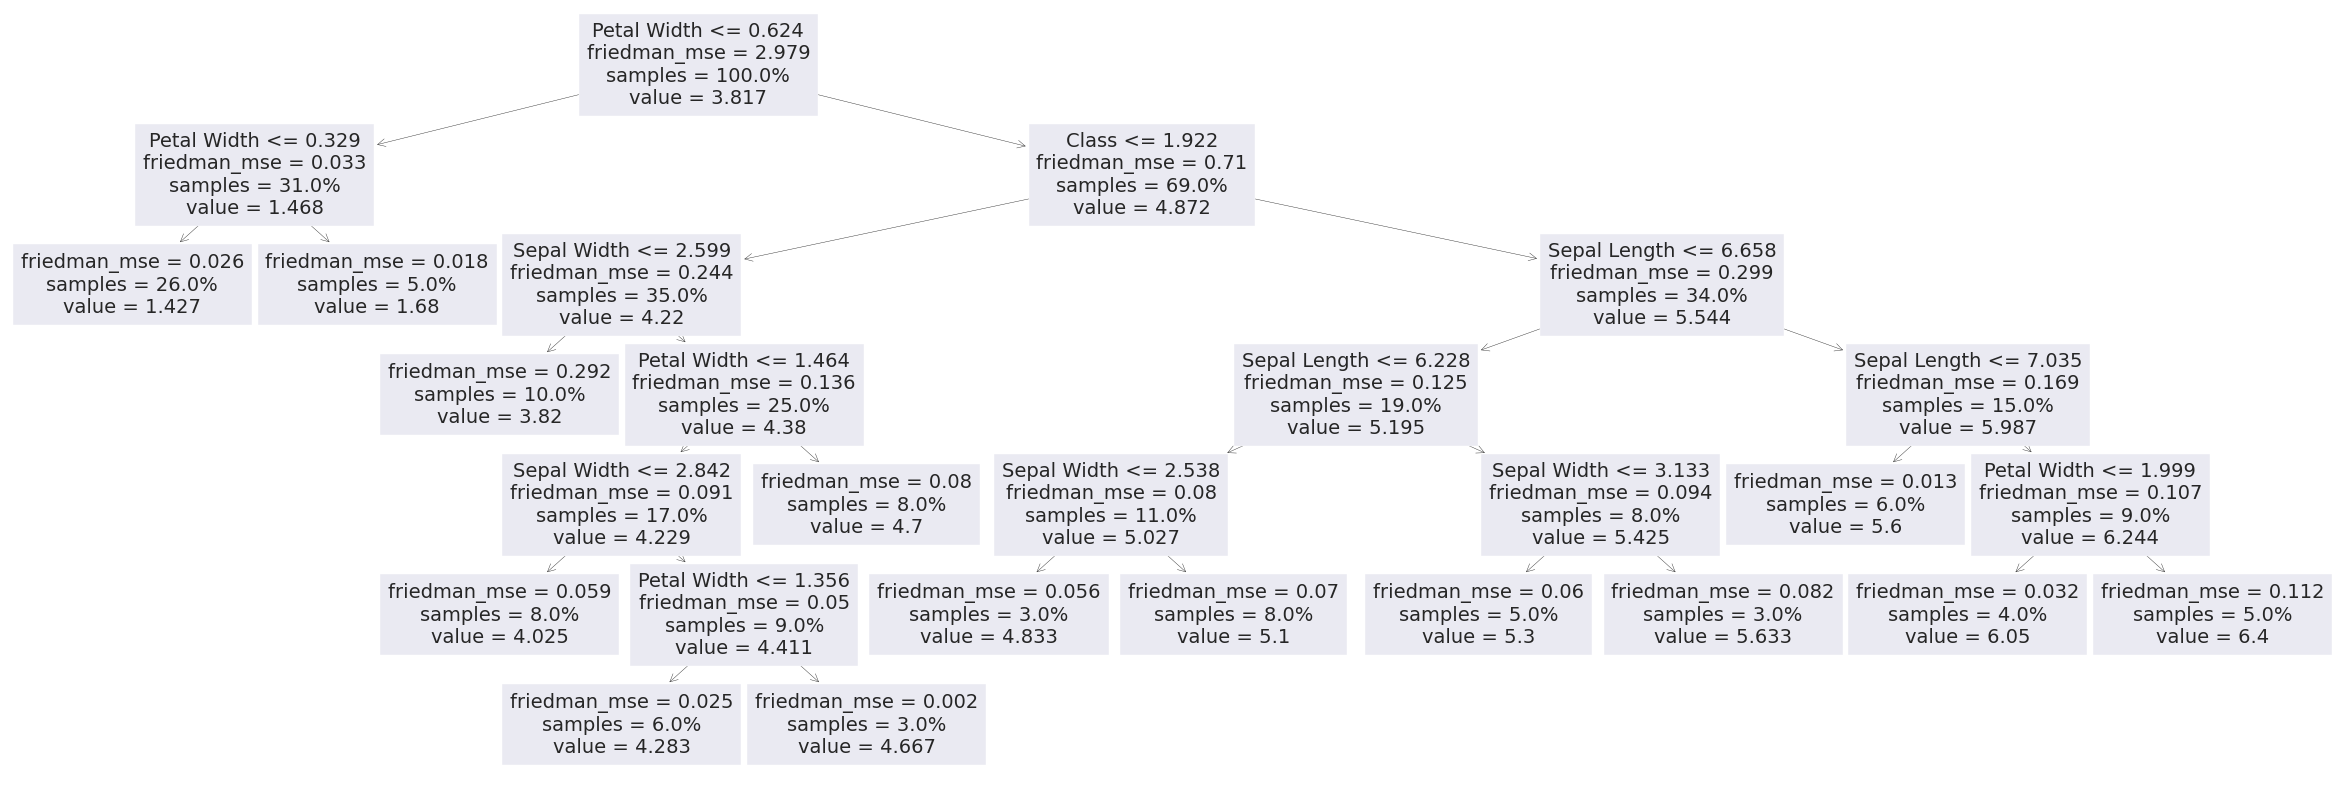

Avg accuracy:  0.9700566824067458


In [32]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.drop("Petal Length", axis=1)
# Predict a continuous variable
df_y = df["Petal Length"]
# Label Encoding
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X, df_y, test_size=0.33, random_state=random_state
)

# Pruning
param_grid = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "splitter": ["best", "random"],
    "max_depth": [3, 10, 30, 50],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_leaf_nodes": [5, 10, 20, 30, 50],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1, 10],
}
regr = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
regr.fit(X_train, Y_train)
print("Best Params:", regr.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": regr.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

# Tree representation: every leaf is a region
# first line: test condition of X_j variable to calculate regions boundaries
# second line: error
# third line: number of train samples fallen in this node
# fourth line: *mean value* of the train samples in this node --> **for the leaf nodes it's the predicted value**
_, ax1 = plt.subplots(1, 1, figsize=(30, 10))
tree.plot_tree(
    regr.best_estimator_,
    filled=False,
    ax=ax1,
    feature_names=df_X.columns,
    proportion=True,
)  # filled: not useful for continuous values, it colors the nodes according to node value
plt.show()

print("Avg accuracy: ", regr.score(X_test, Y_test))

# Text representation
# print(tree.export_text(regr.best_estimator_))

---
### DecisionTreeClassifier
- For **DISCRETE** variables (discrete numerical, ordinal, nominal)
- How to build a Classification tree:
    - Split the predictor space into regions, like Regression Tree
    - For every new/test sample that falls into a region, the prediction is the class most occurring in the region.
    - The boundaries of the regions are chosen according to some **Impurity Measures**:
        - They are indices that measure how well a space is impure: the measure is on its maximum value when all classes are equiprobable (impure); when a class has a probability of 1 (so the others have 0), the measure it's completely pure and it's on its minimum.
            - **Cross-Entropy**: $$ H = -\sum_{i=1}^{K}\log(p_{m,k}) \cdot p_{m,k} $$ where $p_{m,k}$ is the fraction of samples belonging to class $k$ in region $m$ (a probability with respect to the given samples)
            - **Gini**: $$ G = 1 - \sum_{i=1}^{K} p_{m,k}^2$$ it is the total probability of wrong classification
            - **Classification Error Rate**: $$E = 1 - \max_{k} p_{m,k} $$
    - Choosen an Impurity Measure, it's used to calculate the **Information Gain**, that is the (entropy of the parent node) – (average entropy of the child nodes): $$ Gain = I(Parent) - \sum_{j=1}^{k} \frac{N(R_j)}{N} I(R_j) $$
    where $I(*)$ is an Impurity, $N(R_j)$ is the number of samples in the region, $N$ is samples in the parent's region
    - At each step, it's calculated the Gain for all variables $X_i$, and it's chosen the variable with higher Gain. That's the node's variable to split.
    - The cutpoint $s$ for $X_i$ is choosen:
        - If the variable is discrete, use binary or multiway splits (one branch for each value of the variable)
        - If the variable is continuous: discretize the values then treat it as categorical; would consider all distinct values in the dataset  but it's unfeasible, so consider only the points where there is a change in the classification response

Best Params: {'ccp_alpha': 0.001, 'criterion': 'friedman_mse', 'max_depth': 50, 'max_leaf_nodes': 50, 'min_samples_leaf': 3, 'min_samples_split': 4, 'splitter': 'random'}


,Features,Importances
0,Sepal Length,0.71116
1,Sepal Width,0.28884


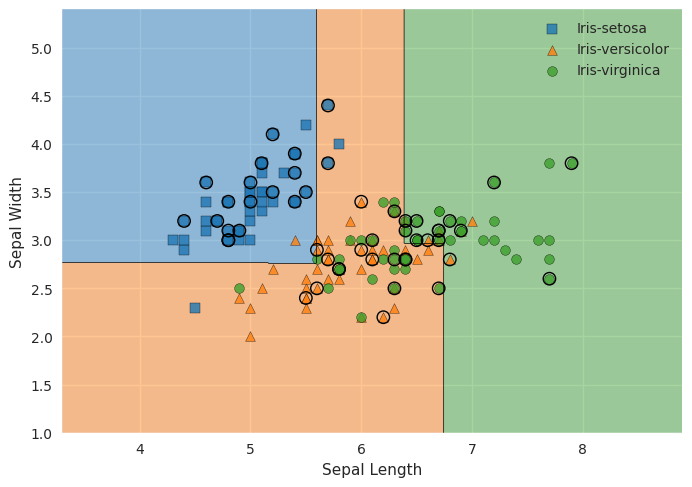

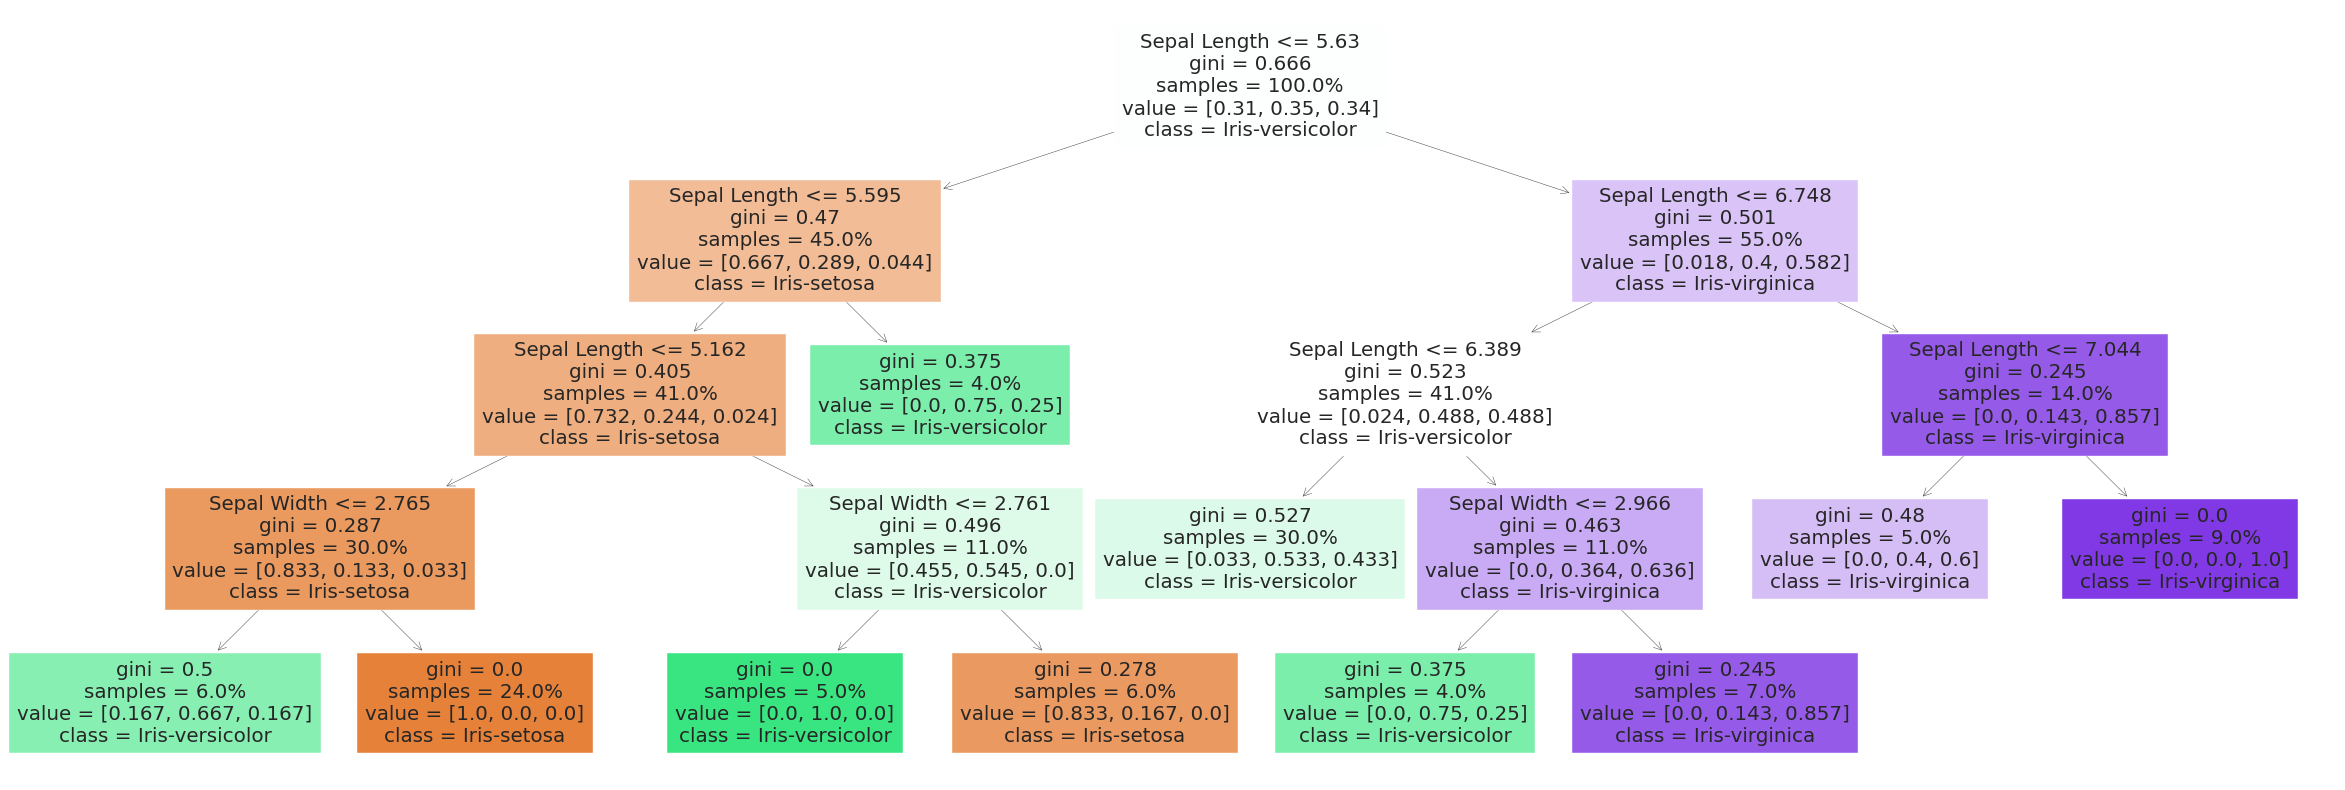

Avg accuracy:  0.72


In [33]:
df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 1]]  # It's considered only two columns
encoder = LabelEncoder()  # Predict a categorical variable
df_y = encoder.fit_transform(df["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# Pruning
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [3, 10, 30, 50],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_leaf_nodes": [5, 10, 20, 30, 50],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1, 10],
}
dtc = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)
dtc.fit(X_train, Y_train)
print("Best Params:", dtc.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": dtc.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

# Plot the regions. For this reason we considered only two columns
# X_highlight=X_test : highlight test values
plot_decision_regions(df_X.values, df_y, clf=dtc, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

# Tree representation: every leaf is a region
# first line: test condition of X_j variable to calculate regions boundaries
# second line: entropy/error
# third line: number of train samples fallen in this node
# fourth line: in which class the samples have fallen. If there are samples in more than one class, the node can further split
_, ax1 = plt.subplots(1, 1, figsize=(30, 10))
tree.plot_tree(
    dtc.best_estimator_,
    filled=True,
    ax=ax1,
    feature_names=df_X.columns,
    class_names=encoder.classes_,
    proportion=True,
)
plt.show()

print("Avg accuracy: ", dtc.score(X_test, Y_test))

---
---
## Bagging
- To reduce the high variance (overfitting), you can average a set of observations: split the training set into several subsets (with replacement) and train a decision tree on each subset, in an independent way
    - For Regression problems: average the predictions
    - For Classification problems: apply majority voting, i.e. return the class most commonly occurring among all tree results
- The subsets of Bagging Trees can still be correlated, because all subtrees will choose to split the same strong variables


---
### Random Forest
- To reduce the correlation among subtrees, RF forces each split to consider only a number of variables much smaller than the available variables
    - The final result is still the average/majority of the subtrees results
- They reduce explainability
- They achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias

In [34]:
# -----------------------------------------------------
# Regression

df = pd.read_csv("datasets/iris.data.txt")
df_X = df.drop("Petal Length", axis=1)
df_y = df["Petal Length"]  # Predict a continuous variable
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# RandomForestRegressor
param_grid = {
    "n_estimators": [10, 100, 1000],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [3, 25, 50],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 3, 5],
    "max_leaf_nodes": [5, 15, 30, 50],
    "n_jobs": [-1],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1],
}
rf_reg = GridSearchCV(
    RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=3
)
rf_reg.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train
print("Best Params:", rf_reg.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": rf_reg.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

print("Avg accuracy: ", rf_reg.score(X_test, Y_test))

Fitting 3 folds for each of 12960 candidates, totalling 38880 fits
[CV 3/3] END bootstrap=True, ccp_alpha=0.0, criterion=squared_error, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.959 total time=   0.1s
[CV 2/3] END bootstrap=True, ccp_alpha=0.0, criterion=squared_error, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.959 total time=   0.1s
[CV 1/3] END bootstrap=True, ccp_alpha=0.0, criterion=squared_error, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=4, n_estimators=10, n_jobs=-1;, score=0.952 total time=   0.1s
[CV 1/3] END bootstrap=True, ccp_alpha=0.0, criterion=squared_error, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.935 total time=   0.1s
[CV 3/3] END bootstrap=True, ccp_alpha=0.0, criterion=squared_error, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_sampl

KeyboardInterrupt: 

In [ ]:
# -----------------------------------------------------
# Classification

df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 1]]  # It's considered only two columns
encoder = LabelEncoder()  # Predict a categorical variable
df_y = encoder.fit_transform(df["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# RandomForestClassifier
param_grid = {
    "n_estimators": [10, 100, 1000],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 25, 50],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 3, 5],
    "max_leaf_nodes": [5, 15, 30, 50],
    "n_jobs": [-1],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1],
}
rf_class = GridSearchCV(
    RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=3
)
rf_class.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train
print("Best Params:", rf_class.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": rf_class.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

# Plot the regions
plot_decision_regions(df_X.values, df_y, clf=rf_class, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

print("Avg accuracy: ", rf_class.score(X_test, Y_test))

Fitting 3 folds for each of 57600 candidates, totalling 172800 fits
[CV 1/3] END bootstrap=True, ccp_alpha=0.0, criterion=gini, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.706 total time=   0.1s
[CV 2/3] END bootstrap=True, ccp_alpha=0.0, criterion=gini, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.636 total time=   0.1s
[CV 3/3] END bootstrap=True, ccp_alpha=0.0, criterion=gini, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=10, n_jobs=-1;, score=0.697 total time=   0.1s
[CV 2/3] END bootstrap=True, ccp_alpha=0.0, criterion=gini, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=3, n_estimators=10, n_jobs=-1;, score=0.727 total time=   0.1s
[CV 1/3] END bootstrap=True, ccp_alpha=0.0, criterion=gini, max_depth=3, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, n_jobs=-1;, sc

KeyboardInterrupt: 

---
---
## Boosting
- It's a General Ensemble technique that allows to combine multiple predictor models
- Boosting builds one tree at a time, unlike Bagging that construct all trees independently
- Boosting algorithms combine several weak learning models to create a strong learning model. The idea behind boosting is to create a complex model from simpler models, each of which focuses on a different subset of the training data. In this way, the final model is better able to generalize than the starting models.

---
### AdaBoost
- AdaBoost works iteratively, training a new decision tree model on a subset of the training data in each iteration. 
- In each iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data: AdaBoost trains a new model *assigning greater weight to the training examples that were misclassified* by the previous model, so that the new model focuses on the more difficult cases (whereas the weights are decreased for those that were predicted correctly). Finally, the decision trees trained in each iteration are combined into a single strong model, through a weighted majority vote (or sum)

In [ ]:
# -----------------------------------------------------
# Regression

df = pd.read_csv("datasets/iris.data.txt")
df_X = df.drop("Petal Length", axis=1)
df_y = df["Petal Length"]  # Predict a continuous variable
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# AdaBoostRegressor
param_grid = {
    "n_estimators": [50, 100, 300, 500, 700, 1000],
    "learning_rate": [0.1, 1, 10, 100],
    "loss": ["linear", "square", "exponential"],
}
ada_reg = GridSearchCV(AdaBoostRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
ada_reg.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train
print("Best Params:", ada_reg.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": ada_reg.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

print("Avg accuracy: ", ada_reg.score(X_test, Y_test))

Best Params: {'learning_rate': 1, 'loss': 'square', 'n_estimators': 100}


,Features,Importances
2,Petal Width,0.549339
3,Class,0.255399
0,Sepal Length,0.157684
1,Sepal Width,0.037578


Avg accuracy:  0.9800516644519845


Best Params: {'learning_rate': 0.01, 'n_estimators': 300}


,Features,Importances
0,Sepal Length,0.576667
1,Sepal Width,0.423333


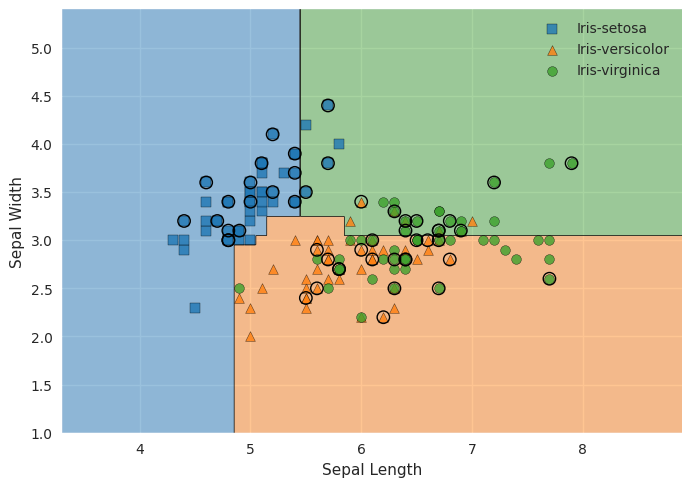

Avg accuracy:  0.64


In [ ]:
# -----------------------------------------------------
# Classification

df = pd.read_csv("datasets/iris.data.txt")
df_X = df.iloc[:, [0, 1]]  # It's considered only two columns
# Predict a categorical variable
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# AdaBoostClassifier
param_grid = {
    "n_estimators": [50, 100, 300, 500, 700, 1000],
    "learning_rate": [0.001, 0.01, 0.1, 1, 10],
}
ada_class = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)
ada_class.fit(X_train, Y_train)
print("Best Params:", ada_class.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {
            "Features": df_X.columns,
            "Importances": ada_class.best_estimator_.feature_importances_,
        }
    ).sort_values("Importances", ascending=False)
)

# Plot the regions
plot_decision_regions(df_X.values, df_y, clf=ada_class, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

print("Avg accuracy: ", ada_class.score(X_test, Y_test))

---
### GradientBoosting

In [ ]:
# -----------------------------------------------------
# Regression

df = pd.read_csv("datasets/iris.data.txt")
df_X = df.drop("Petal Length", axis=1)
# Predict a continuous variable
df_y = df["Petal Length"]
df_X["Class"] = LabelEncoder().fit_transform(df_X["Class"])
X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# GradientBoostingRegressor
param_grid = {
    "loss":['squared_error', 'absolute_error', 'huber', 'quantile'],
    "learning_rate": [0.001, 0.01, 0.1, 1, 10],
    "n_estimators": [10, 100, 500, 1000],
    "criterion": ['friedman_mse', 'squared_error'],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 3, 5],
    "max_depth": [3, 25, 50],
    "max_leaf_nodes": [5, 15, 30, 50],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1],
}
gb_reg = GridSearchCV(
    GradientBoostingRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=3
)
gb_reg.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train
print("Best Params:", gb_reg.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": gb_reg.best_estimator_.feature_importances_}
    ).sort_values("Importances", ascending=False)
)

gb_reg.predict(X_test)
print("Avg accuracy: ", gb_reg.score(X_test, Y_test))

,Features,Importances
3,Class,0.672854
2,Petal Width,0.270465
0,Sepal Length,0.051585
1,Sepal Width,0.005096


Avg accuracy:  0.9672019728619408


,Features,Importances
0,Sepal Length,0.655037
1,Sepal Width,0.344963


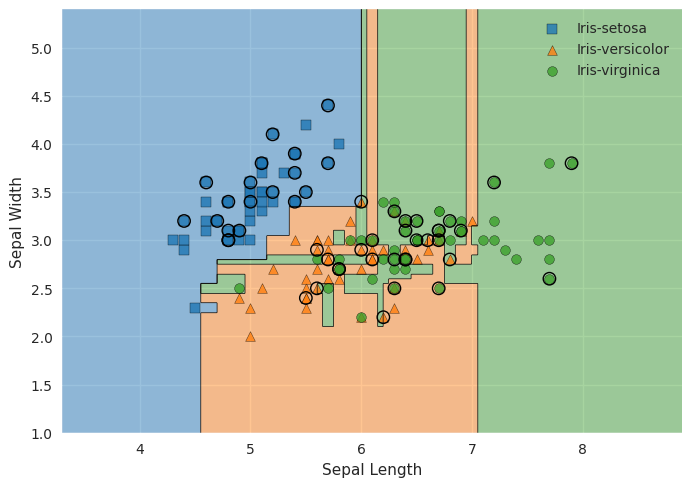

Avg accuracy:  0.7


In [ ]:
# -----------------------------------------------------
# Classification

df = pd.read_csv("datasets/iris.data.txt")

# It's considered only two columns
df_X = df.iloc[:, [0, 1]]
# Predict a categorical variable
encoder = LabelEncoder()
df_y = encoder.fit_transform(df["Class"])

X_train, X_test, Y_train, Y_test = train_test_split(
    df_X.values, df_y, test_size=0.33, random_state=random_state
)

# GradientBoostingClassifier
param_grid = {
    "loss":['log_loss', 'deviance', 'exponential'],
    "learning_rate": [0.001, 0.01, 0.1, 1, 10],
    "n_estimators": [10, 100, 500, 1000],
    "criterion": ['friedman_mse', 'squared_error'],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 3, 5],
    "max_depth": [3, 25, 50],
    "max_leaf_nodes": [5, 15, 30, 50],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1],
}
gb_class = GridSearchCV(
    GradientBoostingClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=3
)
gb_class.fit(X_train, np.ravel(Y_train))  # you need to flat the y_train
print("Best Params:", gb_class.best_params_)

# Impurity-based feature importance
display(
    pd.DataFrame(
        {"Features": df_X.columns, "Importances": gb_class.best_estimator_.feature_importances_}
    ).sort_values("Importances", ascending=False)
)


# Plot the regions
plot_decision_regions(df_X.values, df_y, clf=gb_class, legend=2, X_highlight=X_test)
plt.xlabel(df_X.columns[0])
plt.ylabel(df_X.columns[1])
plt.legend(encoder.classes_)
plt.show()

print("Avg accuracy: ", gb_class.score(X_test, Y_test))